In [26]:
import json
import pickle
import tiktoken
import numpy as np
from xopen import xopen
from tqdm import tqdm
import matplotlib.pyplot as plt
from lost_in_the_middle.metrics import best_subspan_em
from collections import defaultdict
chatgpt_tok = tiktoken.encoding_for_model("gpt-3.5-turbo")

In [ ]:
for ctx_score_cumsum in [0.3, 0.4, 0.5, 0.6]:
    for sent_low in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
        with xopen(f"compressed_qa_predictions/nq_20/dpr_20_fid_doc{ctx_score_cumsum}_sl{sent_low}_sh1.0_tl1.0-Llama-2-13b-chat-hf-predictions.jsonl.gz") as f:
            preds = [json.loads(l) for l in f]
            len_list = []
            for pred in preds:
                len_list.append(len(chatgpt_tok.encode(pred['compressed_prompt'])))
            print(ctx_score_cumsum, sent_low, np.mean(len_list))


In [ ]:
with open('token_scores/token_scores_list_20_documents_gold_at_0_oneContextFalse.pkl', 'rb') as f:
    token_scores_list = pickle.load(f)

In [ ]:
np.array(token_scores_list_9[0][0])

In [2]:
def gini(x):
    mean_absolute_diff = np.abs(np.subtract.outer(x, x)).mean()
    relative_mean_absolute_diff = mean_absolute_diff/np.mean(x)
    g = 0.5 * relative_mean_absolute_diff
    return g


In [3]:
with xopen('compressed_qa_predictions/dpr_nq_20_dev_20/fid_500_ctxTrue_sentTrue0.15_tokFalse1.0_orgidxTrue_Llama-2-13b-chat-hf.jsonl.gz') as f:
    preds = [json.loads(l) for l in f]

In [49]:
low_indices = {}
for gini in [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 'mean']:
    with open(f'gini_low_{gini}_indices.pkl', 'rb') as f:
        gini_low_indices = pickle.load(f)
        low_indices[gini] = gini_low_indices

In [51]:
gini2span_em_list_low_mean = defaultdict(list)
gini2span_em_list_high_mean = defaultdict(list)

for rate in [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]:
    if rate == 0.0:
        sent_comp = False
    else:
        sent_comp = True
        
    with xopen(f'compressed_qa_predictions/dpr_nq_dev_20/fid_500_ctxTrue_sent{sent_comp}{rate}_tokFalse1.0_orgidxTrue_Llama-2-13b-chat-hf.jsonl.gz') as f:
        preds = [json.loads(l) for l in f]
        doc_num_list = []
        span_em_list = []
        gini2span_em_list_low = defaultdict(list)
        gini2span_em_list_high = defaultdict(list)

        for p_i, pred in enumerate(preds):
            cnt = pred['model_prompt'].count('Document [')
            doc_num_list.append(cnt)
            gold_answers = pred["answers"]
            model_answer = pred["model_answer"]
            span_em = best_subspan_em(prediction=model_answer, ground_truths=gold_answers)
            span_em_list.append(span_em)

            for gini, gini_indices in low_indices.items():
                if p_i in gini_indices:
                    gini2span_em_list_low[gini].append(span_em)
                else:
                    gini2span_em_list_high[gini].append(span_em)

        for gini, span_em_list_low in gini2span_em_list_low.items():
            gini2span_em_list_low_mean[gini].append(np.mean(span_em_list_low))
        for gini, span_em_list_high in gini2span_em_list_high.items():
            gini2span_em_list_high_mean[gini].append(np.mean(span_em_list_high))

        print(f'rate: {rate} {np.mean(doc_num_list):.2f}', end=' ')
        print(f'{100 * np.mean(span_em_list):.2f}')
        
        # print(f'low ({len(span_em_list_low)}): {100 * np.mean(span_em_list_low):.2f}', end=' ')
        # print(f'high ({len(span_em_list_high)}): {100 * np.mean(span_em_list_high):.2f}')

rate: 0.05 3.87 59.53
rate: 0.1 4.47 59.45
rate: 0.15 5.06 60.10
rate: 0.2 5.90 60.01
rate: 0.25 6.25 59.87
rate: 0.3 6.96 60.27
rate: 0.35 7.28 59.30
rate: 0.4 7.93 59.97
rate: 0.45 8.12 59.02
rate: 0.5 8.74 58.90


In [107]:
gini2span_em_list_low_mean[0.4]

[0.5848688224527151,
 0.5834045149481392,
 0.5895057962172056,
 0.5888956680902989,
 0.5875533862111043,
 0.5926784624771202,
 0.5821842586943258,
 0.5892617449664429,
 0.5790115924344112,
 0.5782794386821233]

In [105]:
(0.7051915945611866 * 3236 + 0.5442854555334179 * 5521) / 8757

0.6037455749685966

In [108]:
(0.7686832740213523 * 562 + 0.5926784624771202 * 8195) / 8757

0.6039739636861939

In [36]:
np.mean(low_scores)

0.1111111111111111

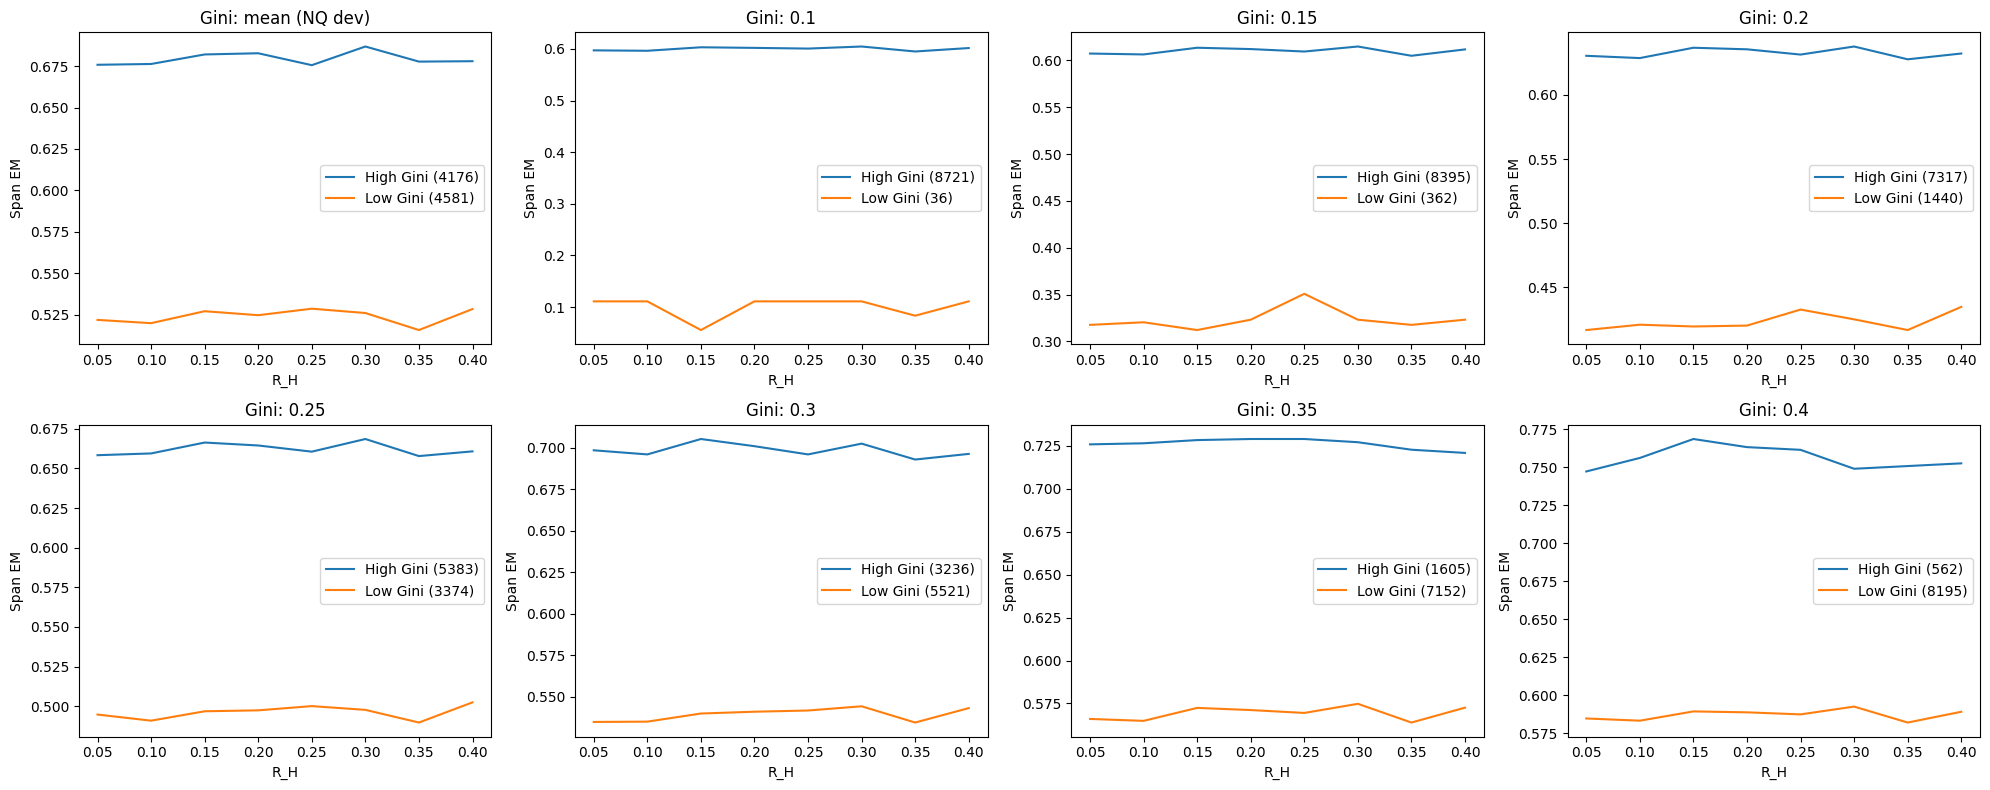

In [61]:
import matplotlib.pyplot as plt

# Assuming you have already defined 'gini2span_em_list_low_mean' and 'gini2span_em_list_high_mean'

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))  # Set figure size; adjust as needed
axes = axes.flatten()  # Flatten the array to easily index it

ginis = ['mean', 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
x = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
indices = [0, 1, 2, 3, 4, 5, 6, 7]

for i, gini in enumerate(ginis):
    low_scores = gini2span_em_list_low_mean[gini]
    high_scores = gini2span_em_list_high_mean[gini]
    
    ax = axes[i]
    x_axis = [x[i] for i in indices]
    high_scores = [high_scores[i] for i in indices]
    low_scores = [low_scores[i] for i in indices]
    ax.plot(x_axis, high_scores, label=f'High Gini ({len(gini2span_em_list_high[gini])})')
    ax.plot(x_axis, low_scores, label=f'Low Gini ({len(gini2span_em_list_low[gini])})')
    
    ax.set_xlabel('R_H')
    ax.set_ylabel('Span EM')
    if gini == 'mean':
        ax.set_title(f'Gini: {gini} (NQ dev)')
    else:
        ax.set_title(f'Gini: {gini}')
    ax.legend()

# Adjust overall layout
plt.tight_layout()
plt.show()

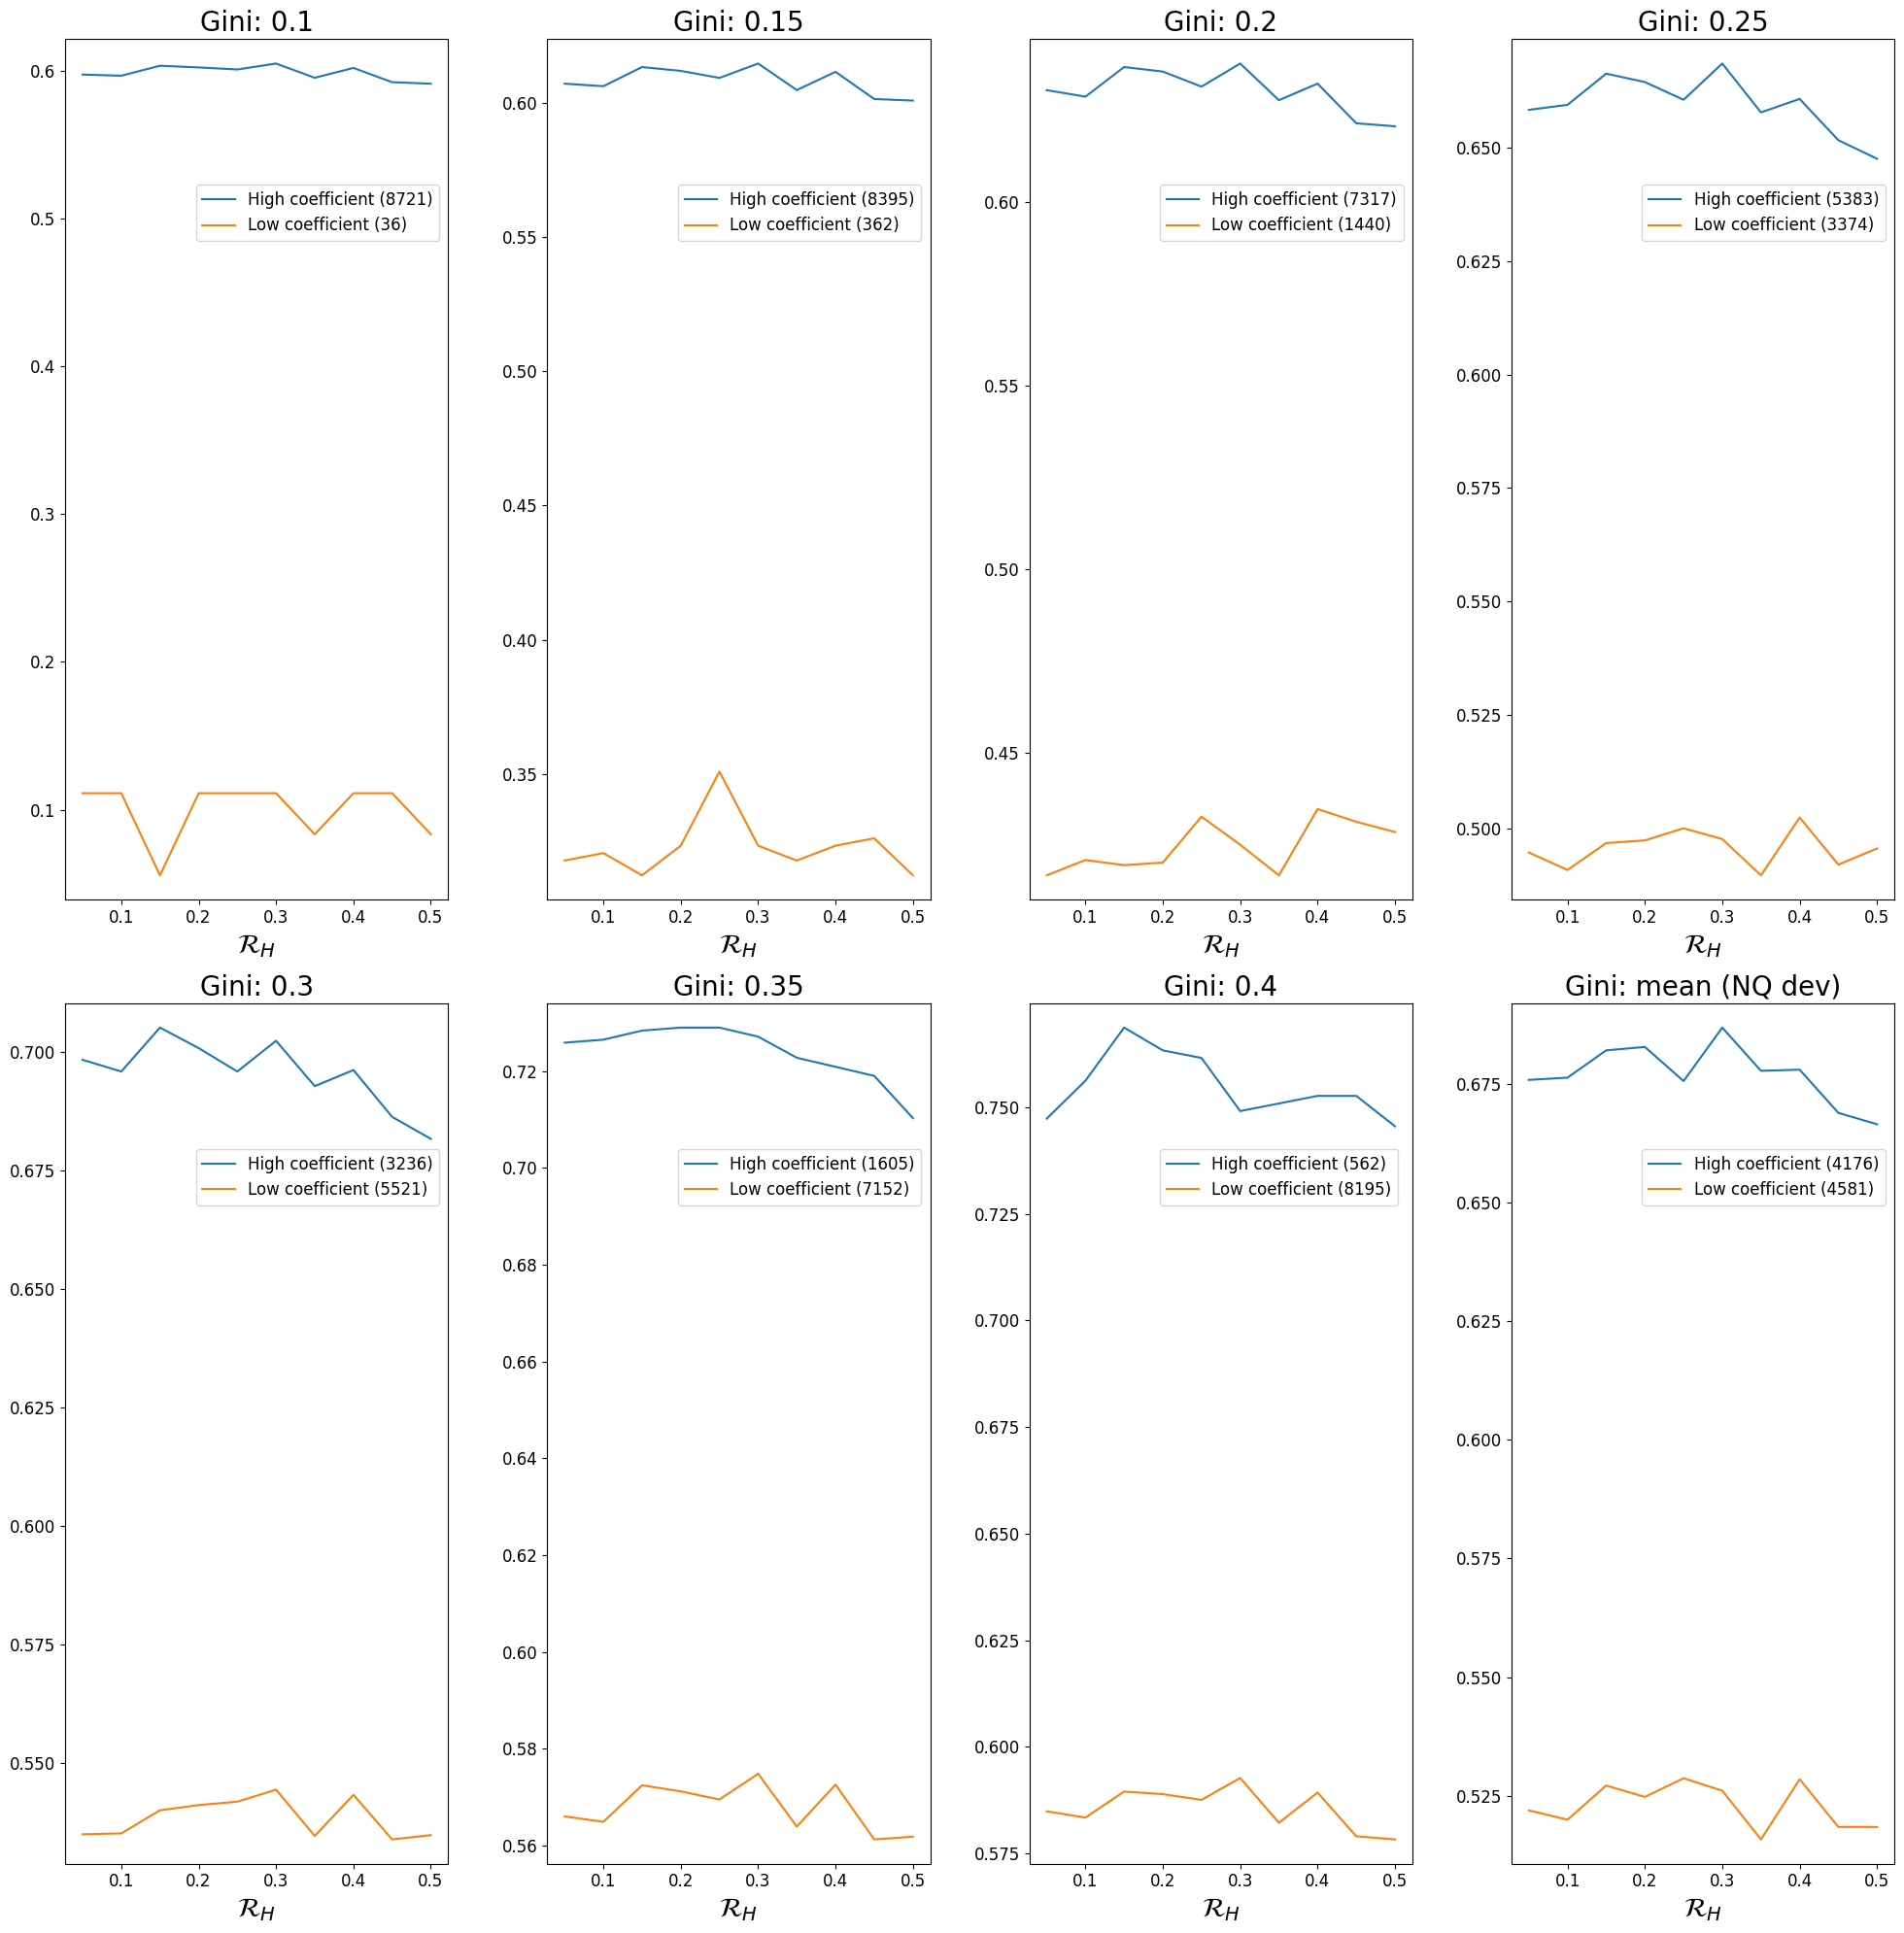

In [100]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already defined 'gini2span_em_list_low_mean' and 'gini2span_em_list_high_mean'
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 20))
axes = axes.flatten()

ginis = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 'mean']
x = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
fontsize = 20
for i, gini in enumerate(ginis):
    low_scores = gini2span_em_list_low_mean[gini]
    high_scores = gini2span_em_list_high_mean[gini]
    ax = axes[i]

    # Plotting the data
    ax.plot(x, high_scores, label=f'High coefficient ({len(gini2span_em_list_high[gini])})')
    ax.plot(x, low_scores, label=f'Low coefficient ({len(gini2span_em_list_low[gini])})')

    # Customizing the y-axis limits to close the gap
    high_min = min(high_scores)
    high_max = max(high_scores)
    low_min = min(low_scores)
    low_max = max(low_scores)
    
    # Find the common range, if overlapping, or close the gap if not
    combined_min = min(low_min, high_min)
    combined_max = max(low_max, high_max)

    # Check if there is overlap
    if high_min < low_max and high_max > low_min:
        # There is overlap
        plot_min = combined_min
        plot_max = combined_max
    else:
        # No overlap, minimize the gap
        plot_min = min(high_min, low_min)
        plot_max = max(high_max, low_max)

    # Reducing vertical space between the two sets of data
    buffer = (plot_max - plot_min) * 0.03  # 10% buffer to avoid cutting off peaks
    ax.set_ylim(plot_min - buffer, plot_max + buffer)
    ## y_tick, x_tick font size
    ax.tick_params(axis='both', which='major', labelsize=fontsize*.6)

    # Setting labels and title
    ax.set_xlabel(r'$\mathcal{R}_H$', fontsize=fontsize)
    # ax.set_ylabel('Span EM', fontsize=14)
    if gini == 'mean':
        ax.set_title(f'Gini: {gini} (NQ dev)', fontsize=fontsize)
    else:
        ax.set_title(f'Gini: {gini}', fontsize=fontsize)
    ax.legend(loc='upper left', bbox_to_anchor=(0.32, 0.84), fontsize=fontsize*.6)
    # ax.legend()

plt.tight_layout()
plt.show()